In [1]:
%matplotlib notebook

import h5py
import matplotlib.pyplot as plt
from numpy import *
import pandas as pd
import os
import sys
import scipy.optimize as opt
from typing import Dict, Any
import recordclass.recordclass as rc
from itertools import product

In [2]:
from LoadingH5 import get_indep_vars, make_iterations_df
h5file = h5py.File('results2D.hdf5',mode='r+')

#Find number of measurements per experiment
measurements = h5file['settings/experiment/measurementsPerIteration'][()]+1
num_its = len(h5file['iterations'])

#Find independent variable names and values
indep_vars = get_indep_vars(h5file)
iVars = list(indep_vars.keys())

# map iterations to independent variable values
iterations = make_iterations_df(h5file, iVars)

## Create n-darray of iteration numbers
* useful when there are multiple independent variables
* Indexing is [ivar1,ivar2,ivar3,...,ivarn]
* ivar ordering is alphabetical
* identical to ordering of keys in indep_vars

In [3]:
from LoadingH5 import fold_to_nd
it_nd = fold_to_nd(iterations)
print(it_nd)

[[ 0  9 18 27 36 45 54 63 72]
 [ 1 10 19 28 37 46 55 64 73]
 [ 2 11 20 29 38 47 56 65 74]
 [ 3 12 21 30 39 48 57 66 75]
 [ 4 13 22 31 40 49 58 67 76]
 [ 5 14 23 32 41 50 59 68 77]
 [ 6 15 24 33 42 51 60 69 78]
 [ 7 16 25 34 43 52 61 70 79]
 [ 8 17 26 35 44 53 62 71 80]]


# Hamamatsu

In [4]:
from HamamatsuH5 import HMROI, set_frame_grabber_region
import HamamatsuH5
# Set ROI
fg = set_frame_grabber_region(h5file)
width = fg['right']-fg['left']
height = fg['bottom']-fg['top']

# For documentation try > help(HMROI)
roi = HMROI(width,height,dic = {
    "left" : 2,
    "right" : 5,
    "top" : 4,
    "bottom" : 7
})

#Load data into memory
shots_per_measurement = int(h5file['/settings/experiment/LabView/camera/shotsPerMeasurement/function'][()])
# pixel-by-pixel data indexed : [iteration, measurement, shot, y-pixel, x-pixel]
hm_pix = HamamatsuH5.load_data(h5file,roi)

#take pixel-by-pixel data and treat it into counter data then mean data
# "count" data indexed : [iteration, measurement, shot]
hm_counts = hm_pix.sum(3).sum(3)
# mean count data indexed : [iteration, shot]
mus = hm_counts.mean(1)
# standard deviation in mean indexed : [iteration, shot]
ers = hm_counts.std(1)/sqrt(measurements)

C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3\HamamatsuH5.py:220: UserWarning: index 51 is out of bounds for axis 1 with size 51
 iteration : 57 measurement : 51 shot 0
  warnings.warn(
C:\Users\Hybrid\Repos\Hybrid_H5\H5_python3\HamamatsuH5.py:220: UserWarning: index 51 is out of bounds for axis 1 with size 51
 iteration : 57 measurement : 51 shot 1
  warnings.warn(


## Plot Histograms of count data

In [41]:
plots = True
if plots and len(iterations) > 22:
    ans = input(f"You're about to plot {len(iterations)} histograms. Are you sure you want to do that? (y/N) : ").upper()[0]
    plots = ans=="Y"
if plots:
    fig,axarr = plt.subplots(len(iterations),1,figsize=(6,4*len(iterations)))
    for iteration, row in iterations.iterrows():
        iteration = int(iteration)
        for shot in range(shots_per_measurement):
            axarr[iteration].hist(hm_counts[iteration,:,shot],histtype='step', label = f"shot {shot}",bins=30)
        axarr[iteration].legend()
        axarr[iteration].set_title(str(row))
else:
    print("You have chosen not to plot the histograms.")
fig.tight_layout()
fig.show()

You're about to plot 81 histograms. Are you sure you want to do that? (y/N)d


## Plot mean count data
* If only 1 iteration : Prints out means for each shot and the corresponding standard deviation
* If there is 1 independent variable : Plot means for each iteration with error bars
* If there are 2 independent variables : show image of means for each iteration.

<IPython.core.display.Javascript object>


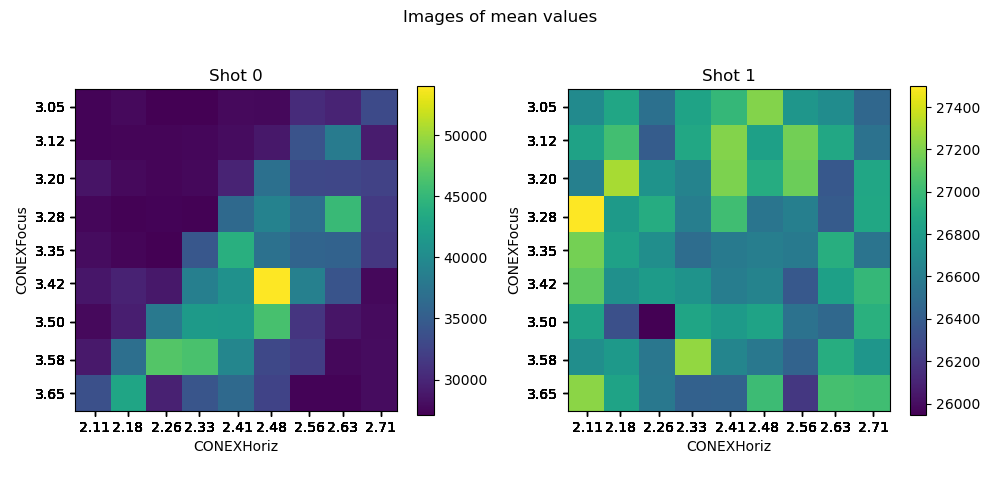

In [51]:
if len(iterations.keys()) == 1:
    for shot in range(shots_per_measurement):
        print(f"shot {shot} rate : {mus[0,shot]} +/- {ers[0,shot]}")
elif len(iterations.keys()) == 2:
    independent_variable = list(iterations.keys())[0]
    xlin = iterations[independent_variable]
    fig,ax = plt.subplots(1,1,figsize=(6,5))
    for shot in range(shots_per_measurement):
        ax.errorbar(xlin, mus[:,shot], yerr=ers[:,shot], label=f"Shot {shot}")
    ax.legend()
    ax.set_ylabel("Counts in ROI")
    ax.set_xlabel(independent_variable)
    fig.show()
elif len(iterations.keys()) == 3:
    fig,axarr = plt.subplots(1,2,figsize=(2*5,5))
    iVars = [key for key in iterations if key != 'iteration']
    pix_size_x = indep_vars[iVars[1]][1] - indep_vars[iVars[1]][0]
    pix_size_y = indep_vars[iVars[0]][1] - indep_vars[iVars[0]][0]
    for shot in range(shots_per_measurement):
        means_nd = fold_to_nd(iterations,mus[:,shot])
        im = axarr[shot].imshow(means_nd, interpolation='none',extent=
                          [min(iterations[iVars[1]]-pix_size_x/2),
                           max(iterations[iVars[1]]+pix_size_x/2),
                           max(iterations[iVars[0]]+pix_size_y/2),
                           min(iterations[iVars[0]]-pix_size_y/2)
                          ])
        fig.colorbar(im, ax=axarr[shot], use_gridspec=True, shrink=.7)
        axarr[shot].set_xlabel(iVars[1])
        axarr[shot].set_ylabel(iVars[0])
        axarr[shot].set_title(f"Shot {shot}")
        axarr[shot].set_xticks(round_(iterations[iVars[1]],2),)
        axarr[shot].set_yticks(round_(iterations[iVars[0]],2))
    fig.tight_layout()
    fig.suptitle("Images of mean values")
    fig.show()
else:
    print("many axes, look for purpose made cells")

## Show images taken within ROI

In [ ]:
## show average image for one shot for each iteration
im_shot = 0 # shot to image

fig,axarr = plt.subplots(len(iterations),1,figsize=(6,4*len(iterations)))
for iteration, row in iterations.iterrows():
    i = row['iteration']
    ivs = {iVar: row[iVar] for iVar in iVars}
    axarr[i].imshow(hm_pix[i,:,im_shot,:,:].mean(0))
    axarr[i].set_title(str(row))
fig.tight_layout()
fig.show()
    
    

## Plot Histgram data of each picture for each iteration
* Very memory hungry!
* Please clear output before saving, copying or pushing if this cell was run

In [ ]:
im_width = roi.right-roi.left
im_height = roi.bottom-roi.top
for iteration, row in iterations.iterrows():
    i = row['iteration']
    fig,axarr = plt.subplots(im_height,im_width,figsize = (10,10))
    for y in range(im_height):
        for x in range(im_width):
            bns = 20
            for shot in range(shots_per_measurement):
                axarr[y,x].hist(hm_pix[i,:,shot,y,x],bins=bns,histtype='step',label = f"Shot {shot}")
            axarr[y,x].set_title(f"x = {x}, y = {y}")
            axarr[y,x].legend()
    fig.suptitle(str(row))
    fig.tight_layout()
    fig.show()

* Ensure once things get better they can get involved in Madison
* Not isolated
* on slack (check)
* check on classes/TAing